--- 1. Carregando e Pré-processando os Dados ---
--- Pré-processamento Concluído ---

--- 2. Dividindo os Dados (Treino e Teste) ---
Tamanho do conjunto de Treino: 319
Tamanho do conjunto de Teste:  137

--- 3. Modelo 5: Treinando o LightGBM ---
Dados de treino: 224 negativos, 95 positivos
Calculando scale_pos_weight: 224 / 95 = 2.3579
Iniciando o treinamento do LightGBM...
--- Treinamento do Modelo 5 Concluído ---

--- 4. Avaliando o Modelo 5 (LightGBM) ---
Acurácia (Modelo 5 - LightGBM): 0.5255

Relatório de Classificação (Modelo 5 - LightGBM):
              precision    recall  f1-score   support

negativo (0)       0.72      0.53      0.61        96
positivo (1)       0.32      0.51      0.39        41

    accuracy                           0.53       137
   macro avg       0.52      0.52      0.50       137
weighted avg       0.60      0.53      0.55       137


Matriz de Confusão (Modelo 5 - LightGBM):
            [Prev. Neg] [Prev. Pos]
[Real Neg]          51         45
[Real P

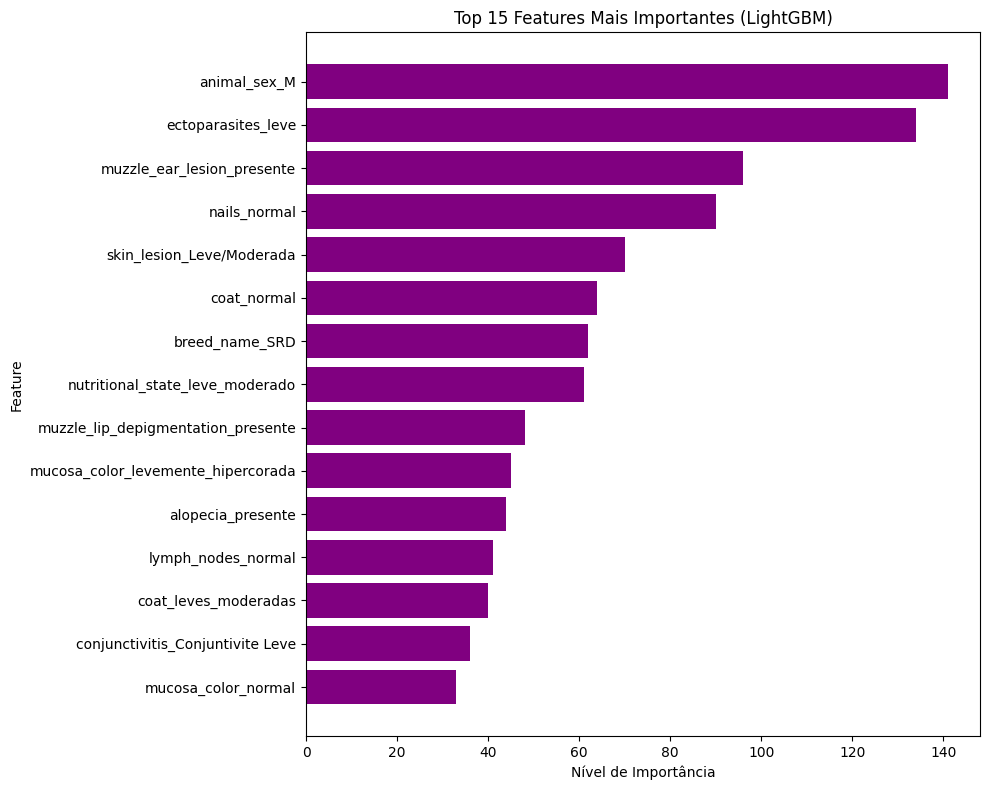

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier # <--- Importamos o LightGBM
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix
)
import matplotlib.pyplot as plt

# ==============================================================================
# --- 1. Carregando e Pré-processando os Dados ---
# ==============================================================================
print("--- 1. Carregando e Pré-processando os Dados ---")

# ... (Seu código de carregamento e pré-processamento) ...
# (Ocultado por brevidade, mas é o mesmo código que você já tem)
# ... (Seu código de carregamento e pré-processamento) ...

# Carregar o dataset
file_path = '../data/raw/leish_dataset.csv'
df = pd.read_csv(file_path)

# Criar cópia para processamento
df_processed = df.copy()

# Lidar com valores ausentes (Missing)
for col in df_processed.select_dtypes(include=['object']).columns:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Codificar a variável Alvo (Target)
target_map = {'positivo': 1, 'negativo': 0, 'Unknown': 0}
df_processed['diagnosis'] = df_processed['diagnosis'].map(target_map).astype(int)

# Separar features (X) e alvo (y)
X_categorical = df_processed.drop('diagnosis', axis=1)
y = df_processed['diagnosis']

# Aplicar One-Hot Encoding nas features categóricas
X_numeric = pd.get_dummies(X_categorical, drop_first=True, dtype=int)
feature_names = X_numeric.columns.tolist() # Salvar nomes das colunas

print("--- Pré-processamento Concluído ---")


# ==============================================================================
# --- 2. Dividindo os Dados (Treino e Teste) ---
# ==============================================================================
print("\n--- 2. Dividindo os Dados (Treino e Teste) ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, 
    y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamanho do conjunto de Treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de Teste:  {X_test.shape[0]}")


# ==============================================================================
# --- 3. Modelo 5: Calculando o Peso e Treinando o LightGBM ---
# ==============================================================================
print("\n--- 3. Modelo 5: Treinando o LightGBM ---")

# 1. Calcular o scale_pos_weight
unique, counts = np.unique(y_train, return_counts=True)
count_neg = counts[0] # Contagem da classe 0 (negativo)
count_pos = counts[1] # Contagem da classe 1 (positivo)
scale_pos_weight_value = count_neg / count_pos

print(f"Dados de treino: {count_neg} negativos, {count_pos} positivos")
print(f"Calculando scale_pos_weight: {count_neg} / {count_pos} = {scale_pos_weight_value:.4f}")

# 2. Inicializar o classificador LightGBM
lgbm_classifier = LGBMClassifier(
    n_estimators=100,             # 100 árvores (como no RF)
    scale_pos_weight=scale_pos_weight_value, # Nosso peso calculado!
    random_state=42,
    n_jobs=-1,
    verbose=-1                    # Desligar mensagens de log durante o treino
)

# 3. Treinar o modelo
print("Iniciando o treinamento do LightGBM...")
lgbm_classifier.fit(X_train, y_train)
print("--- Treinamento do Modelo 5 Concluído ---")


# ==============================================================================
# --- 4. Avaliando o Modelo 5 (LightGBM) ---
# ==============================================================================
print("\n--- 4. Avaliando o Modelo 5 (LightGBM) ---")

# Fazer previsões no conjunto de teste
y_pred_lgbm = lgbm_classifier.predict(X_test)

# Calcular a Acurácia
print(f"Acurácia (Modelo 5 - LightGBM): {accuracy_score(y_test, y_pred_lgbm):.4f}")

# Exibir Relatório de Classificação
print("\nRelatório de Classificação (Modelo 5 - LightGBM):")
print(classification_report(y_test, y_pred_lgbm, target_names=['negativo (0)', 'positivo (1)']))

# Exibir Matriz de Confusão
print("\nMatriz de Confusão (Modelo 5 - LightGBM):")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print(f"            [Prev. Neg] [Prev. Pos]")
print(f"[Real Neg]  {cm_lgbm[0][0]:>10} {cm_lgbm[0][1]:>10}")
print(f"[Real Pos]  {cm_lgbm[1][0]:>10} {cm_lgbm[1][1]:>10}")


# ==============================================================================
# --- 5. BÔNUS: Importância das Features (LightGBM) ---
# ==============================================================================
print("\n\n--- 5. BÔNUS: Importância das Features (LightGBM) ---")

# Extrair a importância de cada feature
importances = lgbm_classifier.feature_importances_

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False) # Ordenar da mais importante para a menos

print("Top 10 features mais importantes para o diagnóstico (LightGBM):")
print(feature_importance_df.head(10))

# --- Plotar as features mais importantes ---
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)

plt.barh(top_features['feature'], top_features['importance'], color='purple')
plt.title('Top 15 Features Mais Importantes (LightGBM)')
plt.xlabel('Nível de Importância')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  
plt.tight_layout()      

# Salvar o gráfico
plt.savefig('lightgbm_feature_importance.png')
print("\nGráfico de importância das features salvo em 'lightgbm_feature_importance.png'")